# Data import section

In [1]:
import pandas as pd
import numpy as np

# high-speed map dataset import
file_name = "../data/nanoindent_maps/Al-Cu Eutectic 1um.csv"

# Load your data
# Assuming Data is a DataFrame
# Read the CSV file, skipping the second row with units
Data = pd.read_csv(file_name, delimiter=',', decimal=',', quotechar='"', skiprows=[1])

# Reorder the columns
ordered_columns = ['Load', 'Depth', 'HARDNESS', 'MODULUS', 'X Position', 'Y Position']
Data = Data[ordered_columns]
Data = Data.astype('float64')

# Clean NaN and data errors
threshold_value = 5000  # Define your threshold value on HARDNESS

# Identify rows where HARDNESS values are NaN or greater than threshold_value
rows_to_remove = Data['HARDNESS'].isna() | (Data['HARDNESS'] > threshold_value)

# Remove these rows from the DataFrame
Data = Data[~rows_to_remove]

# Remove outlayers section

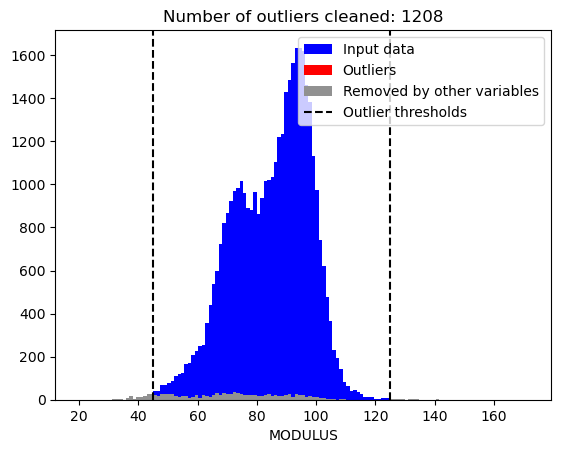

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming Data is already defined
# Remove outliers based on interquartile range (IQR)
treshold = 1.5
Q1 = Data[['Load', 'Depth', 'HARDNESS', 'MODULUS']].quantile(0.25)
Q3 = Data[['Load', 'Depth', 'HARDNESS', 'MODULUS']].quantile(0.75)
IQR = Q3 - Q1

thresholdLow = Q1 - treshold * IQR
thresholdHigh = Q3 + treshold * IQR

outliers = ((Data[['Load', 'Depth', 'HARDNESS', 'MODULUS']] < thresholdLow) |
            (Data[['Load', 'Depth', 'HARDNESS', 'MODULUS']] > thresholdHigh)).any(axis=1)

filteredData = Data[~outliers]
outliersForPlot = Data[outliers]

# Variable to show:
show_var = 'MODULUS'

# Display results
plt.figure()
bin_edges = np.histogram_bin_edges(Data[show_var], bins='auto')
bin_edges = np.unique(np.concatenate((bin_edges, [thresholdLow[show_var], thresholdHigh[show_var]])))
bin_edges = bin_edges[np.isfinite(bin_edges)]

# Plot input data
plt.hist(Data[show_var], bins=bin_edges, alpha=1, label='Input data', color='blue')

# Plot outliers
plt.hist(outliersForPlot[show_var], bins=bin_edges, alpha=1, label='Outliers', color='red')

# Plot data removed by other variables
mask = outliers & ~outliersForPlot[show_var].isna()
plt.hist(Data[show_var][mask], bins=bin_edges, alpha=1, label='Removed by other variables', color=[145/255, 145/255, 145/255])

# Plot outlier thresholds
plt.axvline(thresholdLow[show_var], color='black', linestyle='--', label='Outlier thresholds')
plt.axvline(thresholdHigh[show_var], color='black', linestyle='--')

plt.title(f"Number of outliers cleaned: {outliersForPlot.shape[0]}")
plt.legend()
plt.xlabel(show_var)
plt.show()

# Data Statistics

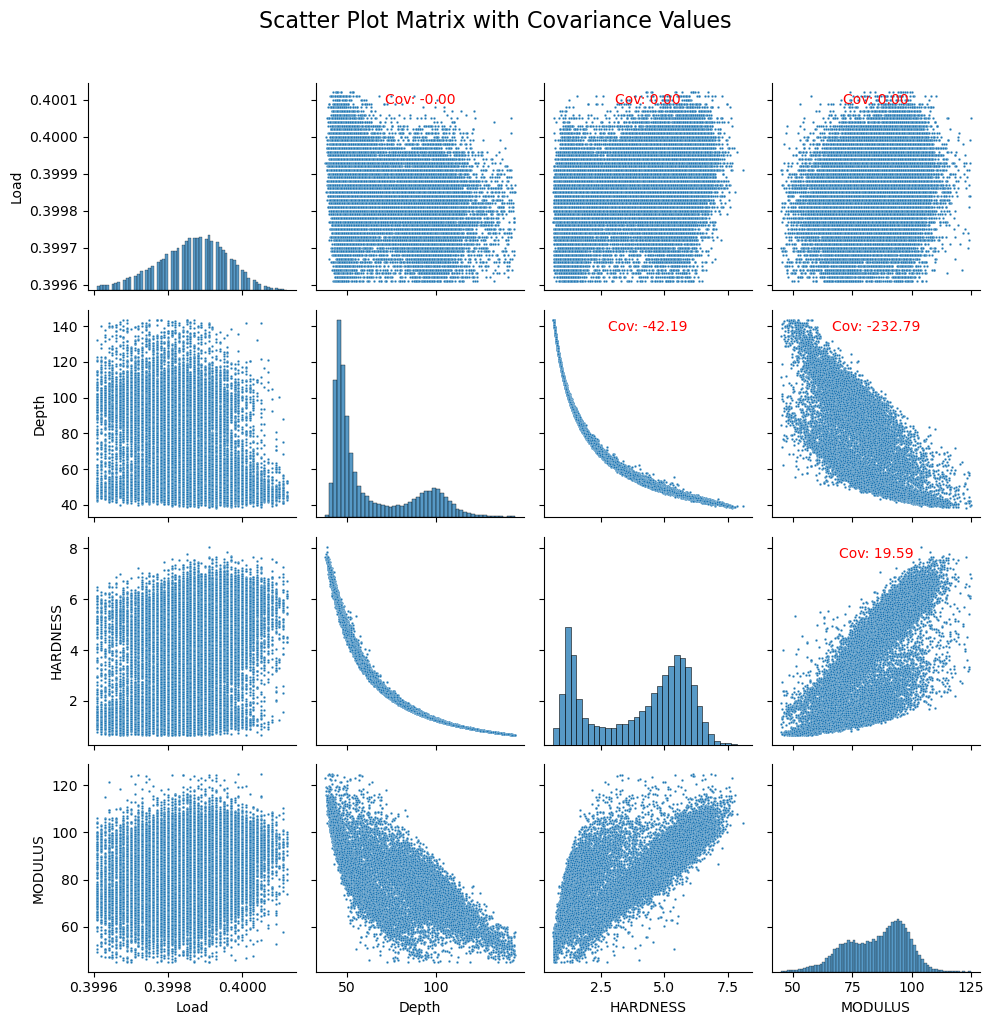

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant columns
data = filteredData[['Load', 'Depth', 'HARDNESS', 'MODULUS']]

# Compute the covariance matrix
cov_matrix = data.cov()

# Create a pairplot with scatter plots and histograms
pairplot = sns.pairplot(data, kind='scatter', diag_kind='hist', plot_kws={'s': 3})

# Add the covariance values to the plots
for i, j in zip(*np.triu_indices_from(cov_matrix, 1)):
    ax = pairplot.axes[i, j]
    ax.annotate(f'Cov: {cov_matrix.iloc[i, j]:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=10, color='red')

plt.suptitle('Scatter Plot Matrix with Covariance Values', y=1.02, fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


# High-speed maps plotting

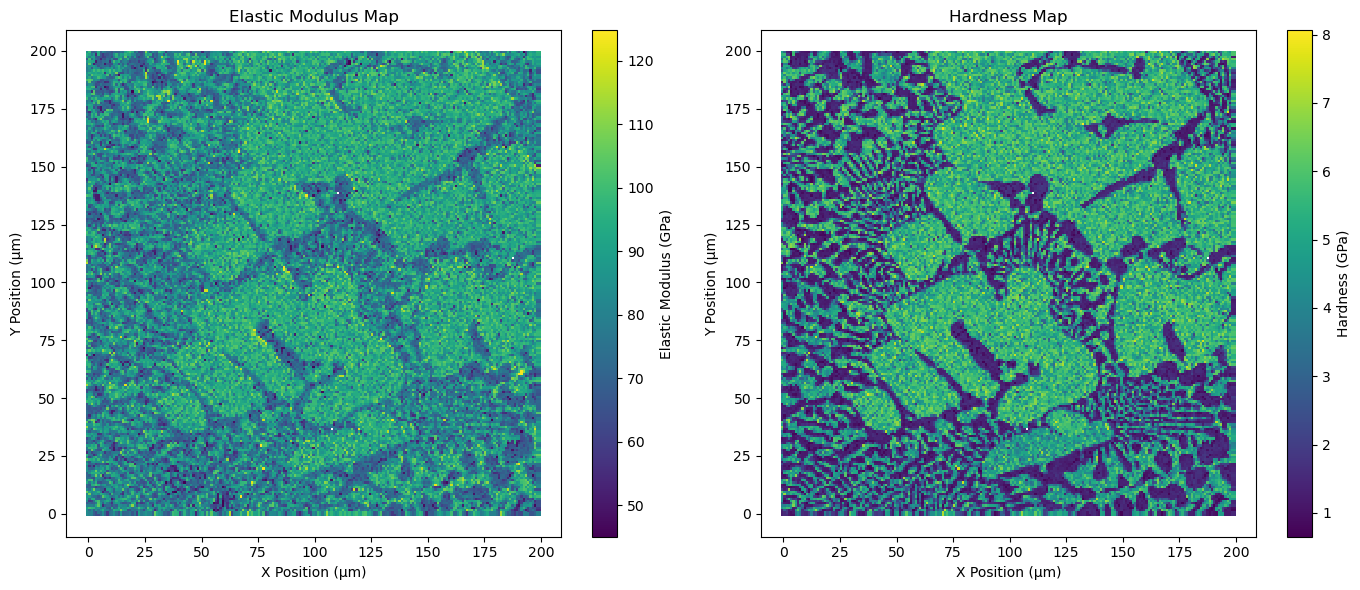

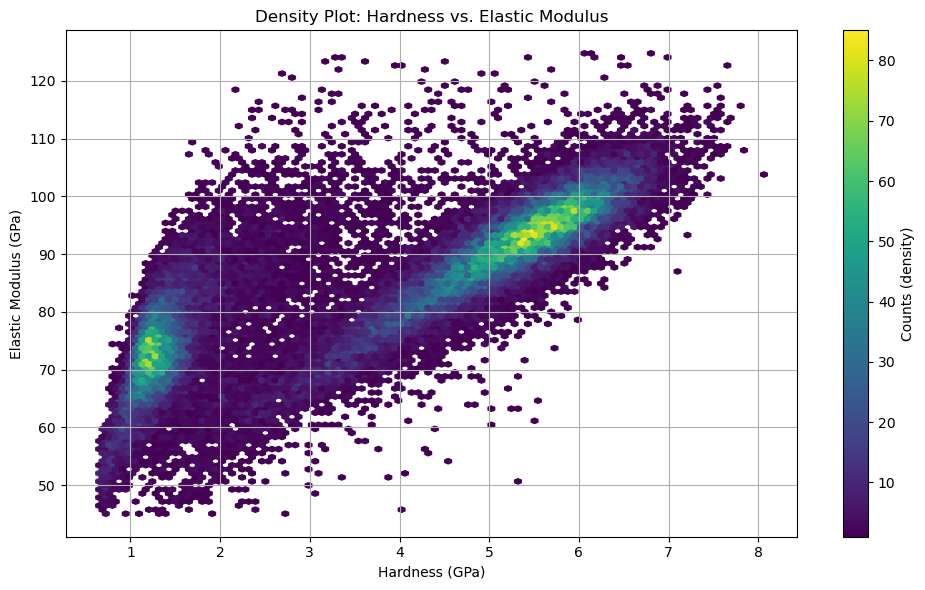

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Spatial Maps: Elastic Modulus and Hardness
# --------------------------------------------------

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Elastic Modulus Map (scatter with square markers)
sc1 = ax[0].scatter(
    filteredData['X Position'],
    filteredData['Y Position'],
    c=filteredData['MODULUS'],
    cmap='viridis',         # Monochromatic gradient
    s=12,                   # Marker size
    marker='s',             # Square marker
    edgecolor='none'
)
cb1 = plt.colorbar(sc1, ax=ax[0])
cb1.set_label('Elastic Modulus (GPa)')

ax[0].set_xlabel('X Position (μm)')
ax[0].set_ylabel('Y Position (μm)')
ax[0].set_title('Elastic Modulus Map')
ax[0].set_aspect('equal')
ax[0].axis('tight')  # Ensure axis tightly fits data

# Hardness Map (same settings)
sc2 = ax[1].scatter(
    filteredData['X Position'],
    filteredData['Y Position'],
    c=filteredData['HARDNESS'],
    cmap='viridis',
    s=12,
    marker='s',
    edgecolor='none'
)
cb2 = plt.colorbar(sc2, ax=ax[1])
cb2.set_label('Hardness (GPa)')

ax[1].set_xlabel('X Position (μm)')
ax[1].set_ylabel('Y Position (μm)')
ax[1].set_title('Hardness Map')
ax[1].set_aspect('equal')
ax[1].axis('tight')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2D Density Plot: Hardness vs. Modulus
# --------------------------------------------------

plt.figure(figsize=(10, 6))

hb = plt.hexbin(
    filteredData['HARDNESS'],
    filteredData['MODULUS'],
    gridsize=100,
    cmap='viridis',
    mincnt=1
)

cb = plt.colorbar(hb)
cb.set_label('Counts (density)')

plt.xlabel('Hardness (GPa)')
plt.ylabel('Elastic Modulus (GPa)')
plt.title('Density Plot: Hardness vs. Elastic Modulus')

plt.grid(True)
plt.tight_layout()
plt.show()

# 1-D GMM deconvolution

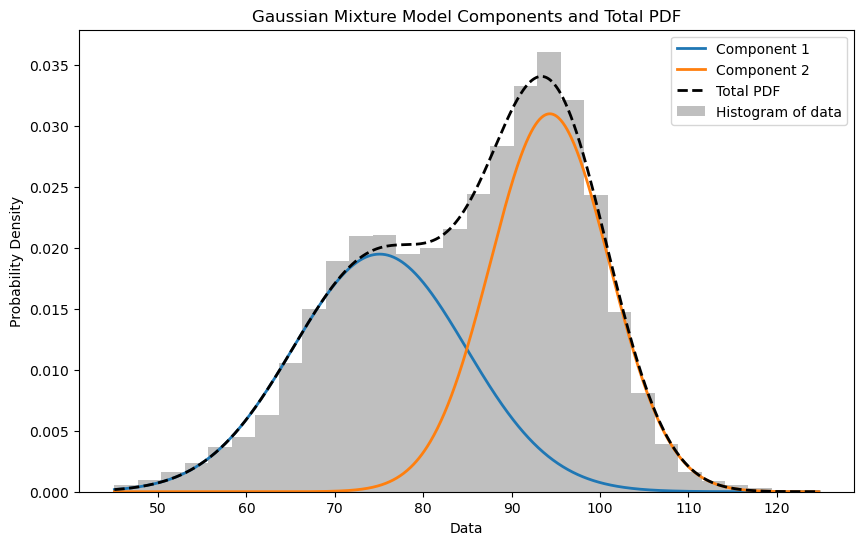

        Mean  StandardDeviation  Proportions
0  75.068050           9.771641     0.477367
1  94.317006           6.725942     0.522633


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

def GMMdeconvo(data, numComponents):
    # Fit the GMM
    best_gmm = None
    best_bic = np.inf

    # Options equivalent to MATLAB's statset
    max_iter = 10000
    tol = 1e-7

    # Multiple random starts
    for _ in range(10):
        gmm = GaussianMixture(n_components=numComponents, max_iter=max_iter, tol=tol, n_init=10, random_state=1, reg_covar=0.001)
        gmm.fit(data.reshape(-1, 1))
        current_bic = gmm.bic(data.reshape(-1, 1))
        if current_bic < best_bic:
            best_bic = current_bic
            best_gmm = gmm

    # Assuming best_gmm is your fitted GMM model
    x_values = np.linspace(data.min(), data.max(), 1000)
    total_pdf = np.zeros_like(x_values)

    # Plot each Gaussian component
    plt.figure(figsize=(10, 6))
    for i in range(best_gmm.n_components):
        # For each component, calculate its PDF
        mean = best_gmm.means_[i][0]
        std = np.sqrt(best_gmm.covariances_[i][0][0])
        pdf_values = norm.pdf(x_values, mean, std)

        # Scale the PDF by the component's mixing proportion
        scaled_pdf = pdf_values * best_gmm.weights_[i]

        # Plot the component's PDF
        plt.plot(x_values, scaled_pdf, linewidth=2, label=f'Component {i+1}')

        # Add the scaled PDF to the total PDF
        total_pdf += scaled_pdf

    # Plot the total PDF
    plt.plot(x_values, total_pdf, 'k--', linewidth=2, label='Total PDF')

    # Plot the histogram of the data
    plt.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Histogram of data', edgecolor='none')

    plt.title('Gaussian Mixture Model Components and Total PDF')
    plt.xlabel('Data')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()

    # Create the table with means, standard deviations, and proportions
    means = best_gmm.means_.flatten()
    std_devs = np.sqrt(best_gmm.covariances_.flatten())
    proportions = best_gmm.weights_

    GaussianComponents = pd.DataFrame({
        'Mean': means,
        'StandardDeviation': std_devs,
        'Proportions': proportions
    })

    return GaussianComponents

# Example usage
data = filteredData['MODULUS'].values  # Replace 'MODULUS' with the desired channel
numComponents = 2  # Set the number of components
GaussianComponents = GMMdeconvo(data, numComponents)
print(GaussianComponents)

# PCA Analysis

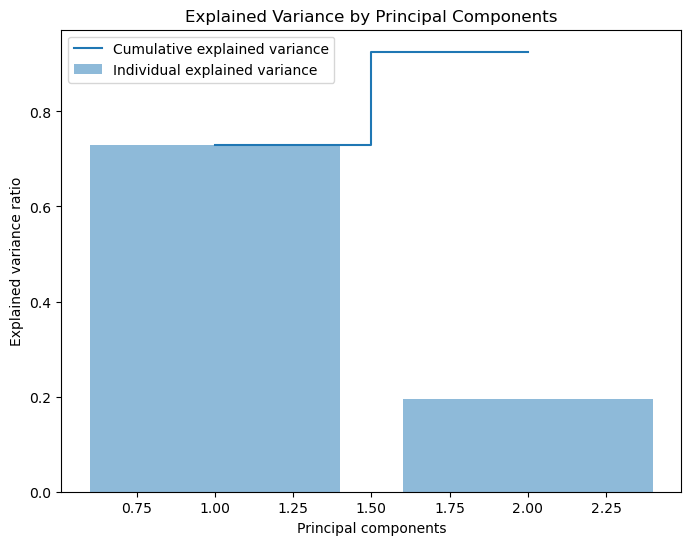

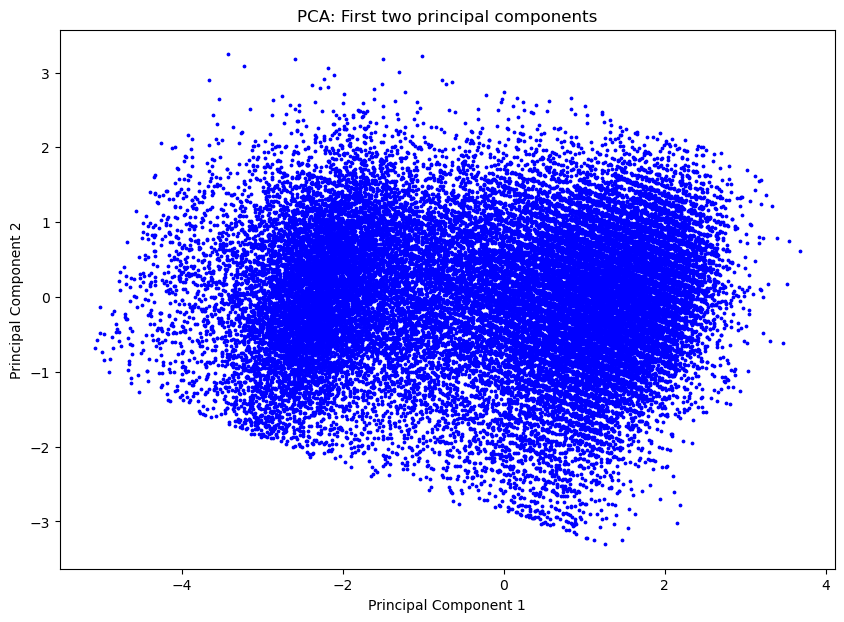

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming filteredData is a DataFrame with 'X Position', 'X Position', 'MODULUS', and 'HARDNESS' columns

# Select the relevant columns and standardize the data
features = ['MODULUS', 'HARDNESS', 'Load', 'Depth']
x = filteredData.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.title('Explained Variance by Principal Components')
plt.show()

# Plot the data in the space of the first two principal components
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'], c='blue', s=3)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First two principal components')
plt.show()

# K-means clustering

Cluster sizes (K-means): {0: 12447, 1: 15542, 2: 10803}


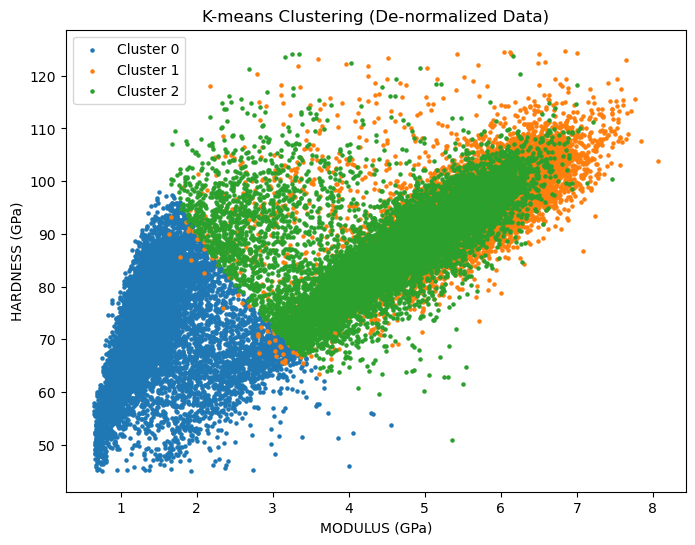

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Parameters
K = 3
N_INIT = 10
RANDOM_STATE = 1

# Features for clustering
kmeans_features = ['MODULUS', 'HARDNESS', 'Load', 'Depth']
kmeans_data = filteredData[kmeans_features].values

# Define a scaler specific for K-means (4 features)
scaler_kmeans = StandardScaler()
kmeans_data_scaled = scaler_kmeans.fit_transform(kmeans_data)

# Fit K-means
kmeans_model = KMeans(n_clusters=K, init='k-means++', n_init=N_INIT, random_state=RANDOM_STATE)
kmeans_labels = kmeans_model.fit_predict(kmeans_data_scaled)

# Cluster statistics
unique_labels_kmeans = np.unique(kmeans_labels)
cluster_sizes_kmeans = {label: np.sum(kmeans_labels == label) for label in unique_labels_kmeans}
print(f"Cluster sizes (K-means): {cluster_sizes_kmeans}")

# --- Plot clusters directly in de-normalized MODULUS vs HARDNESS ---
plt.figure(figsize=(8, 6))
for i in range(K):
    idx = kmeans_labels == i
    plt.scatter(filteredData.loc[idx, 'HARDNESS'], 
                filteredData.loc[idx, 'MODULUS'], 
                s=5, label=f'Cluster {i}')

plt.title('K-means Clustering (De-normalized Data)')
plt.xlabel('MODULUS (GPa)')
plt.ylabel('HARDNESS (GPa)')
plt.legend()
plt.show()

# GMM Clustering

Cluster sizes (GMM): {0: 23785, 1: 9895, 2: 5112}


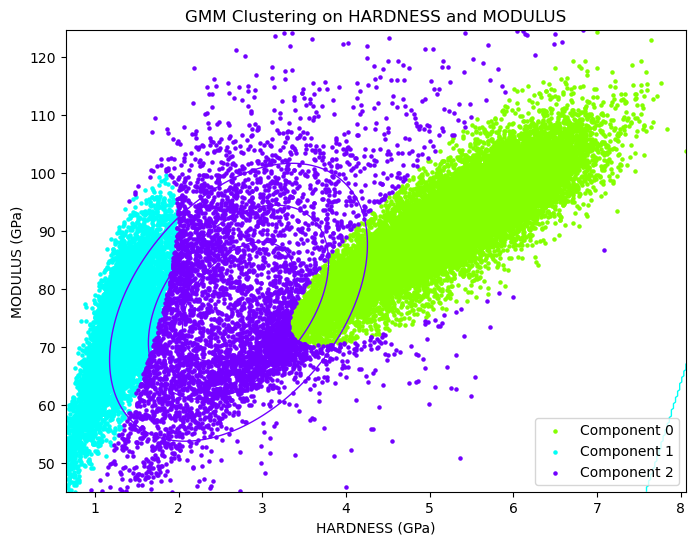

In [21]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

# Parameters
NUM_COMPONENTS = 3
MAX_ITER = 10000
TOL = 1e-7
INIT_RESTARTS = 10

# Data for GMM clustering
gmm_data = filteredData[['HARDNESS', 'MODULUS']].values  # Using physical values

# Use a new scaler fitted on these 2 columns
scaler_gmm = StandardScaler()
gmm_data_scaled = scaler_gmm.fit_transform(gmm_data)

# Fit GMM
gmm_model = GaussianMixture(
    n_components=NUM_COMPONENTS,
    covariance_type='full',
    max_iter=MAX_ITER,
    tol=TOL,
    n_init=INIT_RESTARTS,
    random_state=1
)
gmm_model.fit(gmm_data_scaled)
gmm_labels = gmm_model.predict(gmm_data_scaled)

# Cluster statistics
unique_labels_gmm = np.unique(gmm_labels)
cluster_sizes_gmm = {label: np.sum(gmm_labels == label) for label in unique_labels_gmm}
print(f"Cluster sizes (GMM): {cluster_sizes_gmm}")

# Plotting clusters
plt.figure(figsize=(8, 6))
colors = sns.color_palette("hsv", NUM_COMPONENTS)
for i, color in enumerate(colors):
    idx = gmm_labels == i
    plt.scatter(gmm_data[idx, 0], gmm_data[idx, 1], s=5, color=color, label=f'Component {i}')

plt.xlabel('HARDNESS (GPa)')
plt.ylabel('MODULUS (GPa)')
plt.title('GMM Clustering on HARDNESS and MODULUS')
plt.legend(loc='best')

# Contour plot of Gaussian components
x = np.linspace(gmm_data[:, 0].min(), gmm_data[:, 0].max(), 300)
y = np.linspace(gmm_data[:, 1].min(), gmm_data[:, 1].max(), 300)
X, Y = np.meshgrid(x, y)

# Use the same scaler as GMM for transformation
XY_scaled = scaler_gmm.transform(np.column_stack((X.ravel(), Y.ravel())))

# Compute per-component PDF
pdfs = np.zeros((NUM_COMPONENTS, XY_scaled.shape[0]))
for i in range(NUM_COMPONENTS):
    mean = gmm_model.means_[i]
    cov = gmm_model.covariances_[i]
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    diff = XY_scaled - mean
    exponent = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
    pdfs[i, :] = np.exp(-0.5 * exponent) / np.sqrt((2 * np.pi)**2 * det_cov)

for i, color in enumerate(colors):
    plt.contour(X, Y, pdfs[i].reshape(X.shape), levels=3, colors=[color], linewidths=1)

plt.show()

# Cluster Statistics

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score

# Helper function to compute per-cluster averages
def cluster_averages(dataframe, labels):
    """Compute average MODULUS and HARDNESS per cluster."""
    results = []
    unique_labels = np.unique(labels)
    for cluster in unique_labels:
        cluster_data = dataframe[labels == cluster]
        avg_modulus = cluster_data['MODULUS'].mean()
        avg_hardness = cluster_data['HARDNESS'].mean()
        size = len(cluster_data)
        results.append({
            "Cluster": cluster,
            "Size": size,
            "Avg MODULUS (GPa)": avg_modulus,
            "Avg HARDNESS (GPa)": avg_hardness
        })
    return pd.DataFrame(results)

# --- GMM ---
gmm_stats = cluster_averages(filteredData, gmm_labels)
num_clusters_gmm = len(gmm_stats)
avg_size_gmm = gmm_stats["Size"].mean()
silhouette_gmm = silhouette_score(gmm_data_scaled, gmm_labels)

# --- K-means ---
kmeans_stats = cluster_averages(filteredData, kmeans_labels)
num_clusters_kmeans = len(kmeans_stats)
avg_size_kmeans = kmeans_stats["Size"].mean()
silhouette_kmeans = silhouette_score(kmeans_data_scaled, kmeans_labels)

# Combined summary
summary_stats = pd.DataFrame({
    "Algorithm": ["GMM", "K-means"],
    "Num Clusters": [num_clusters_gmm, num_clusters_kmeans],
    "Avg Cluster Size": [avg_size_gmm, avg_size_kmeans],
    "Silhouette Score": [silhouette_gmm, silhouette_kmeans],
    "Avg MODULUS (GPa)": [
        gmm_stats["Avg MODULUS (GPa)"].mean(),
        kmeans_stats["Avg MODULUS (GPa)"].mean()
    ],
    "Avg HARDNESS (GPa)": [
        gmm_stats["Avg HARDNESS (GPa)"].mean(),
        kmeans_stats["Avg HARDNESS (GPa)"].mean()
    ]
})

display(summary_stats)

# Optional: show per-cluster details
print("\n--- GMM per-cluster averages ---")
display(gmm_stats)
print("\n--- K-means per-cluster averages ---")
display(kmeans_stats)

,Algorithm,Num Clusters,Avg Cluster Size,Silhouette Score,Avg MODULUS (GPa),Avg HARDNESS (GPa)
0,GMM,3,12930.666667,0.440488,80.754052,3.110343
1,K-means,3,12930.666667,0.352715,84.523991,3.842408



--- GMM per-cluster averages ---


,Cluster,Size,Avg MODULUS (GPa),Avg HARDNESS (GPa)
0,0,23785,91.891533,5.309464
1,1,9895,72.748917,1.290915
2,2,5112,77.621706,2.730649



--- K-means per-cluster averages ---


,Cluster,Size,Avg MODULUS (GPa),Avg HARDNESS (GPa)
0,0,12447,71.576578,1.499092
1,1,15542,93.961360,5.491703
2,2,10803,88.034036,4.536429


# Cluster plotting

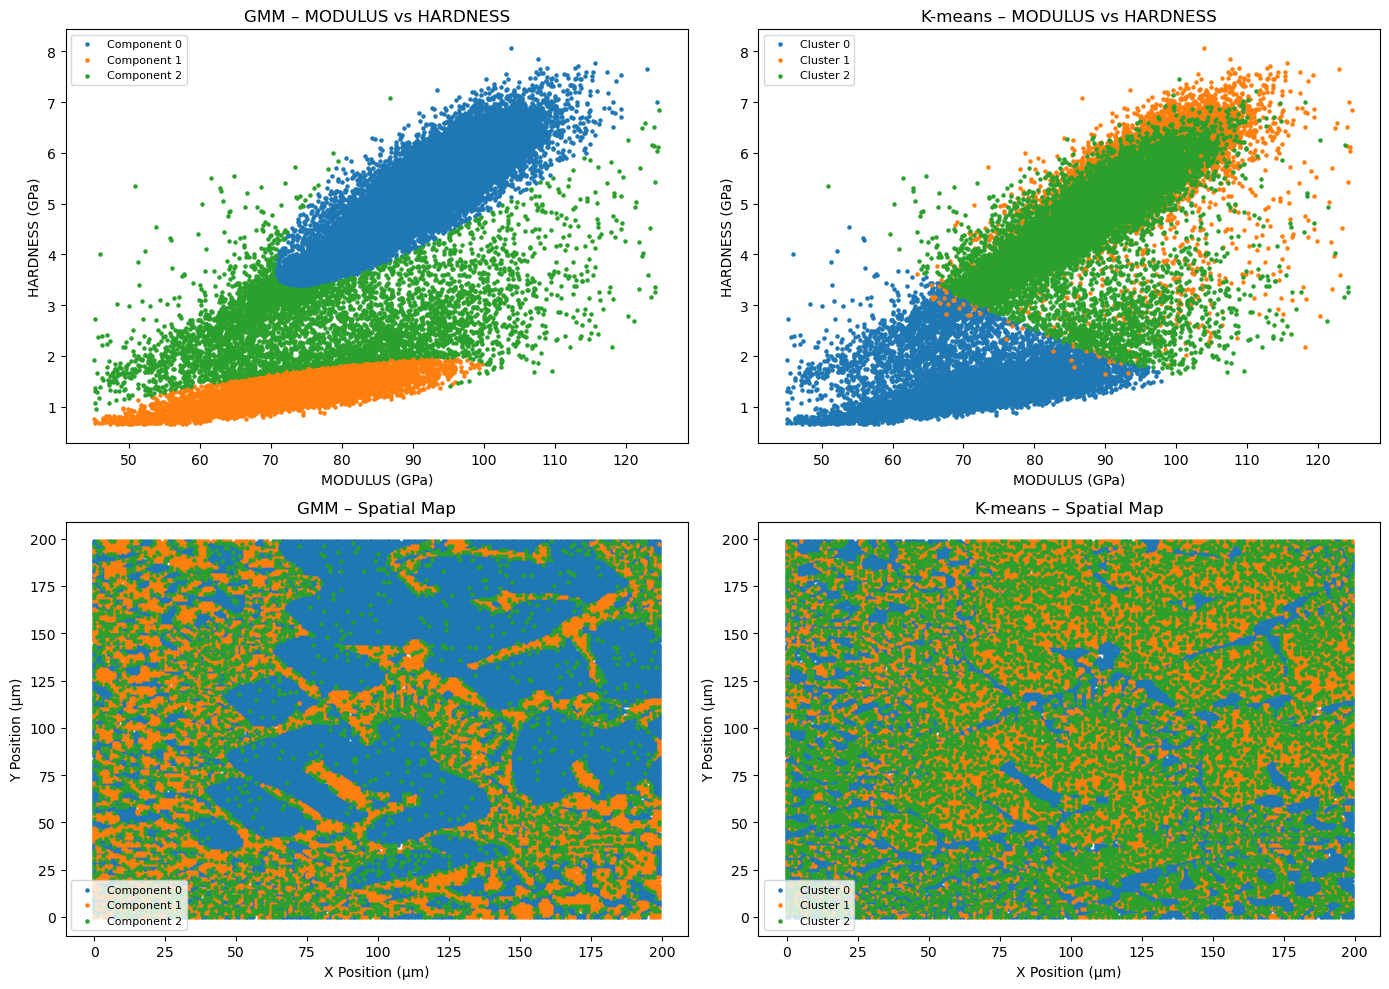

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -------- GMM: MODULUS vs HARDNESS --------
for i in range(NUM_COMPONENTS):
    idx = gmm_labels == i
    axes[0, 0].scatter(filteredData['MODULUS'][idx], 
                       filteredData['HARDNESS'][idx], 
                       s=5, label=f'Component {i}')
axes[0, 0].set_title('GMM – MODULUS vs HARDNESS')
axes[0, 0].set_xlabel('MODULUS (GPa)')
axes[0, 0].set_ylabel('HARDNESS (GPa)')
axes[0, 0].legend(fontsize=8, loc='best')

# -------- GMM: Spatial map (X, Y) --------
for i in range(NUM_COMPONENTS):
    idx = gmm_labels == i
    axes[1, 0].scatter(filteredData['X Position'][idx], 
                       filteredData['Y Position'][idx], 
                       s=5, label=f'Component {i}')
axes[1, 0].set_title('GMM – Spatial Map')
axes[1, 0].set_xlabel('X Position (µm)')
axes[1, 0].set_ylabel('Y Position (µm)')
axes[1, 0].legend(fontsize=8, loc='best')

# -------- K-means: MODULUS vs HARDNESS --------
for i in range(K):
    idx = kmeans_labels == i
    axes[0, 1].scatter(filteredData['MODULUS'][idx], 
                       filteredData['HARDNESS'][idx], 
                       s=5, label=f'Cluster {i}')
axes[0, 1].set_title('K-means – MODULUS vs HARDNESS')
axes[0, 1].set_xlabel('MODULUS (GPa)')
axes[0, 1].set_ylabel('HARDNESS (GPa)')
axes[0, 1].legend(fontsize=8, loc='best')

# -------- K-means: Spatial map (X, Y) --------
for i in range(K):
    idx = kmeans_labels == i
    axes[1, 1].scatter(filteredData['X Position'][idx], 
                       filteredData['Y Position'][idx], 
                       s=5, label=f'Cluster {i}')
axes[1, 1].set_title('K-means – Spatial Map')
axes[1, 1].set_xlabel('X Position (µm)')
axes[1, 1].set_ylabel('Y Position (µm)')
axes[1, 1].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()